# Amazon Fine Food Reviews: Improving the Classification
4 ways to improve the classification performance on the amazon fine food review dataset.

In [0]:
from keras.callbacks import Callback
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.datasets import imdb


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# needed in Google Colaboratory for callback plots:
from IPython.display import clear_output
# needed in notebooks for plotting:
%matplotlib inline

import pandas as pd

import time

!pip install gensim
import gensim

    100% |████████████████████████████████| 23.6MB 1.9MB/s 
    100% |████████████████████████████████| 1.4MB 14.4MB/s 
    100% |████████████████████████████████| 133kB 25.6MB/s 
    100% |████████████████████████████████| 61kB 22.6MB/s 
    100% |████████████████████████████████| 5.0MB 6.5MB/s 
    100% |████████████████████████████████| 552kB 22.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
class LogCallback(Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []
    self.fig = plt.figure()
    self.logs = []
    self.start_time = time.time()

  def on_epoch_end(self, epoch, logs={None}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.i += 1
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('acc'))
    self.val_acc.append(logs.get('val_acc'))

    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    clear_output(wait=True)

    ax1.plot(self.x, self.losses, label="loss")
    ax1.plot(self.x, self.val_losses, label="validation loss")
    ax1.legend()

    ax2.plot(self.x, self.acc, label="accuracy")
    ax2.plot(self.x, self.val_acc, label="validation accuracy")
    ax2.legend()

    plt.show()

  def on_train_end(self, logs=None):
    print(f'Total training time: {time.time()-self.start_time:.2f} sec.')
    print(f'Training log data:')
    for i in range(len(self.losses)):
      print(f'{i:2d}: {self.losses[i]} - {self.acc[i]} ')
    print(f'Validation log data:')
    for i in range(len(self.losses)):
      print(f'{i:2d}: {self.val_losses[i]} - {self.val_acc[i]} ')
       
        
live_plot = LogCallback()

In [0]:
#utilities
def imdb_idx2word(dataset):
  # map imdb IDs back to words
  INDEX_FROM = 3   # word index offset
  imdb_word2idx = imdb.get_word_index()
  imdb_word2idx = {k:(v+INDEX_FROM) for k,v in imdb_word2idx.items()}
  imdb_word2idx["<PAD>"] = 0
  imdb_word2idx["<START>"] = 1
  imdb_word2idx["<UNK>"] = 2

  imdb_idx2word = {value:key for key,value in imdb_word2idx.items()}
  
  reviews = []
  for review in dataset:
    reviews.append([imdb_idx2word[word] for word in review])
  return reviews

def embedding_idx2word(idx, word_mdoel):
  if idx in word_model.wv.index2word:
    return word_model.wv.index2word[idx]
  else:
    return '0'
  
def embedding_word2idx(word, word_model):
  if word in word_model.wv.vocab:
    return word_model.wv.vocab[word].index
  else:
    return 0


## Load  the data
Load the csv-file in a pandas dataframe and take a look at its columns and labels. 

In [0]:
max_features = 20000
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')




Loading data...
25000 train sequences
25000 test sequences


In [0]:
x_train = imdb_idx2word(x_train)
x_test = imdb_idx2word(x_test)


In [0]:
word_model = gensim.models.fasttext.FastText(x_train, size=100)
pretrained_weights = word_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape
  
for i in range(len(x_train)):
  x_train[i] = [embedding_word2idx(word, word_model) for word in x_train[i]]
for i in range(len(x_test)):
  x_test[i] = [embedding_word2idx(word, word_model) for word in x_test[i]]

In [0]:
# pad sequences
maxlen = 80
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print(x_train[0])

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

[   12   254     0     1     4  3735     2   721    34    69    41   527
   474    23   397   315    44     4     0 11927  1026    10   102    86
     0   379    12   295    96    30  2065    54    23   139     3   192
  7477    15     0   224    19    18   132   474    23   478     2   142
    27  5515    15    49    34    25   222    90    22   102     0   224
    63    13    36  1332    86     9    13   281     2    13  4451   111
   101    30    12    13  5341    16   176    30]


## Pre-trained embeddings
The original implementation as starting point.

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1999800   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 2,080,402
Trainable params: 80,602
Non-trainable params: 1,999,800
_________________________________________________________________
None


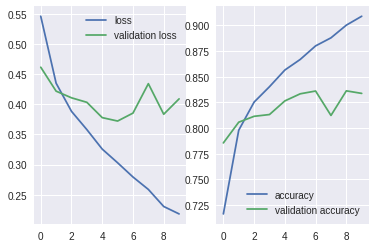

Total training time: 454.73 sec.
Training log data:
 0: 0.5458115672492981 - 0.7163200000190735 
 1: 0.4347810256576538 - 0.7978399999618531 
 2: 0.38816891248703 - 0.8252400000190735 
 3: 0.3578590129852295 - 0.84024 
 4: 0.32553416648387906 - 0.8564799999809265 
 5: 0.30286597403526305 - 0.8668 
 6: 0.2792622958946228 - 0.88 
 7: 0.2586790147781372 - 0.887839999961853 
 8: 0.23037807482719422 - 0.9002000000190735 
 9: 0.21807333111524582 - 0.90888 
Validation log data:
 0: 0.46129268303871157 - 0.785479999961853 
 1: 0.4216181099033356 - 0.805680000038147 
 2: 0.4105732905483246 - 0.8113999999809265 
 3: 0.4031051277256012 - 0.8131199999809265 
 4: 0.3777162823009491 - 0.8264000000190734 
 5: 0.37205507117271425 - 0.8333199999809265 
 6: 0.3852291141414642 - 0.8360400000381469 
 7: 0.43402789673805237 - 0.8122399999809266 
 8: 0.383343530292511 - 0.836200000038147 
 9: 0.4088136758804321 - 0.8337199999809265 


In [0]:
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test), callbacks=[live_plot])